In [1]:
% matplotlib inline
# base modules
import os
import pickle
from datetime import datetime
import csv
# downloaded modules
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import theano
import theano.tensor as T
import lasagne
import time
from sklearn.utils import shuffle
from numpy import float32
from nolearn.lasagne import NeuralNet
from pandas import read_csv
import pandas as pd
print 'done'

Couldn't import dot_parser, loading of dot files will not be possible.
done


Using gpu device 0: GeForce GT 750M


In [2]:
# with open('normfaces.pkl', 'wb') as pk:
#     pickle.dump((train_data, test_data), pk)
    
with open('normfaces.pkl', 'rb') as pk:
    train_data, test_data = pickle.load(pk)

In [3]:
# isolate columns 

def get_features():
    for i, col in enumerate(train_data.columns):
        if i % 2 == 0:
            if col != 'Image':
                df = train_data.iloc[:,[i,i+1,30]].copy()
                yield df.dropna()


feats= get_features()

featurenames = []

for i, col in enumerate(train_data.columns):

    if i % 2 == 0:
        if col != 'Image':
#             print col[:-2]
            featurenames.append(col[:-2])
            exec "%s = next(feats)" % col[:-2]

print featurenames

['left_eye_center', 'right_eye_center', 'left_eye_inner_corner', 'left_eye_outer_corner', 'right_eye_inner_corner', 'right_eye_outer_corner', 'left_eyebrow_inner_end', 'left_eyebrow_outer_end', 'right_eyebrow_inner_end', 'right_eyebrow_outer_end', 'nose_tip', 'mouth_left_corner', 'mouth_right_corner', 'mouth_center_top_lip', 'mouth_center_bottom_lip']


In [4]:
def reverse_feature(feature, additional):
    if additional is None:
#         print 'got here 1'
        reversed_feature = feature.copy()
    else:
#         print 'got here 2'
        reversed_feature = additional.copy()
        reversed_feature.columns = list(feature.columns)

    reversed_feature.iloc[:,0] = 96 - reversed_feature.iloc[:,0]
    reversed_feature['Image'] = reversed_feature['Image'].apply(lambda image: image.reshape(96,96)[:, ::-1].reshape(9216) )
    return feature.append(reversed_feature)
    
    
features = ['left_eye_center', 'right_eye_center', 'left_eye_inner_corner', 'left_eye_outer_corner', 'right_eye_inner_corner', 'right_eye_outer_corner', 'left_eyebrow_inner_end', 'left_eyebrow_outer_end', 'right_eyebrow_inner_end', 'right_eyebrow_outer_end', 'nose_tip', 'mouth_left_corner', 'mouth_right_corner', 'mouth_center_top_lip', 'mouth_center_bottom_lip']
revlist=[]
for feat in features:
    if feat[:5] == 'left_':
        add = 'right_' + feat[5:]
        print feat, add
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
#         print execstring
        exec execstring
    elif feat[:5] == 'right':
        add = 'left' + feat[5:]
        print feat, add
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
#         print execstring
        exec execstring
    elif feat[:10] == 'mouth_left':
        add = 'mouth_right' + feat[10:]
        print feat, add
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
#         print execstring
        exec execstring
    elif feat[:10] == 'mouth_righ':
        add = 'mouth_lef' + feat[10:]
        print feat, add
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
#         print execstring
        exec execstring
    else:
        print feat
        exec '%s_rev = reverse_feature(%s, None)' %( feat, feat )
    revlist.append(feat+'_rev')

for feat in features:
    exec '%s=None' % feat
    
print revlist

left_eye_center right_eye_center
right_eye_center left_eye_center
left_eye_inner_corner right_eye_inner_corner
left_eye_outer_corner right_eye_outer_corner
right_eye_inner_corner left_eye_inner_corner
right_eye_outer_corner left_eye_outer_corner
left_eyebrow_inner_end right_eyebrow_inner_end
left_eyebrow_outer_end right_eyebrow_outer_end
right_eyebrow_inner_end left_eyebrow_inner_end
right_eyebrow_outer_end left_eyebrow_outer_end
nose_tip
mouth_left_corner mouth_right_corner
mouth_right_corner mouth_left_corner
mouth_center_top_lip
mouth_center_bottom_lip
['left_eye_center_rev', 'right_eye_center_rev', 'left_eye_inner_corner_rev', 'left_eye_outer_corner_rev', 'right_eye_inner_corner_rev', 'right_eye_outer_corner_rev', 'left_eyebrow_inner_end_rev', 'left_eyebrow_outer_end_rev', 'right_eyebrow_inner_end_rev', 'right_eyebrow_outer_end_rev', 'nose_tip_rev', 'mouth_left_corner_rev', 'mouth_right_corner_rev', 'mouth_center_top_lip_rev', 'mouth_center_bottom_lip_rev']


In [5]:
from scipy.ndimage.filters import gaussian_filter

def blur_training_data(feature):
    blurred_feature = feature.copy()
    blurred_feature['Image'] = blurred_feature['Image'].apply(lambda image: gaussian_filter(image.reshape(96,96),3).reshape(9216) )
    return feature.append(blurred_feature)
    
blurlist = []
for feat in revlist:
    print feat,
    exec '%s_blur = blur_training_data(%s)' % (feat, feat)
    blurlist.append('%s_blur' % feat)
    exec '%s=None' % feat
print blurlist

left_eye_center_rev right_eye_center_rev left_eye_inner_corner_rev left_eye_outer_corner_rev right_eye_inner_corner_rev right_eye_outer_corner_rev left_eyebrow_inner_end_rev left_eyebrow_outer_end_rev right_eyebrow_inner_end_rev right_eyebrow_outer_end_rev nose_tip_rev mouth_left_corner_rev mouth_right_corner_rev mouth_center_top_lip_rev mouth_center_bottom_lip_rev ['left_eye_center_rev_blur', 'right_eye_center_rev_blur', 'left_eye_inner_corner_rev_blur', 'left_eye_outer_corner_rev_blur', 'right_eye_inner_corner_rev_blur', 'right_eye_outer_corner_rev_blur', 'left_eyebrow_inner_end_rev_blur', 'left_eyebrow_outer_end_rev_blur', 'right_eyebrow_inner_end_rev_blur', 'right_eyebrow_outer_end_rev_blur', 'nose_tip_rev_blur', 'mouth_left_corner_rev_blur', 'mouth_right_corner_rev_blur', 'mouth_center_top_lip_rev_blur', 'mouth_center_bottom_lip_rev_blur']


In [3]:
def features_to_numpy(df, test=False):
    df = df.dropna()
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        y = y / 96  # scale target coordinates to [-1, 1]
#         X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        return X, y
    return X
    
# # execute
# for feature in blurlist:
#     print feature,
#     exec "%s_tr, %s_lb = features_to_numpy(%s)" % (feature, feature, feature)
#     exec '%s=None' % feature
# print blurlist

In [16]:
def plotface(data, labels, n=0):
    plt.imshow(data[n].reshape(96,96), cmap='gray')
    for i, crd in enumerate([ labels[n][i:i+2]*96 for i in xrange(0,len(labels[n]),2) ]):
    #     print i, crd
        if i == -1: # left eye red
            plt.plot(crd[0], crd[1], 'y.')
        elif i == 1:# right eye yellow
            plt.plot(crd[0], crd[1], 'r.')
        else:
            plt.plot(crd[0], crd[1], 'c.')
    plt.title('left-eye yellow, right eye red')
    plt.draw()

7037


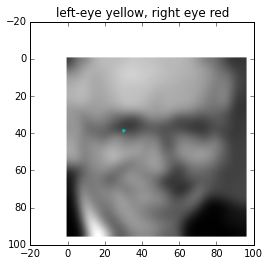

In [8]:
print left_eye_center_rev_blur_tr.shape[0]/4
plotface(right_eye_center_rev_blur_tr, right_eye_center_rev_blur_lb, n=-2+4*7037)

In [4]:
def examine_results(fname):
    with open(fname, 'rb') as fin:
        results = pickle.load(fin)
    plt.plot(results[0])
    plt.plot(results[1],'r-')
    plt.yscale('log')
    plt.title('Trainign Accuracies by Epoch\nBlue = Train, Red = Validation')
    plt.show()

In [5]:
def output_for_kaggle(predictions, fdir='../submissions'):
    submission_format = pd.read_csv('../dataraw/IdLookupTable.csv').iloc[:,1:3]
    
    outname = os.path.join(fdir, 'submission-%s.csv' % datetime.now().strftime('%Y%m%d%H%M%S') )
    
    print np.where(predictions > 1)
    predictions[np.where(predictions > 1)] = 1
    predictions[np.where(predictions < 0)] = 0
    print predictions[np.where(predictions > 1)]
    predictions = predictions*96
    
    out = pd.DataFrame(predictions)
    out.columns = [u'left_eye_center_x', u'left_eye_center_y', u'right_eye_center_x',
       u'right_eye_center_y', u'left_eye_inner_corner_x',
       u'left_eye_inner_corner_y', u'left_eye_outer_corner_x',
       u'left_eye_outer_corner_y', u'right_eye_inner_corner_x',
       u'right_eye_inner_corner_y', u'right_eye_outer_corner_x',
       u'right_eye_outer_corner_y', u'left_eyebrow_inner_end_x',
       u'left_eyebrow_inner_end_y', u'left_eyebrow_outer_end_x',
       u'left_eyebrow_outer_end_y', u'right_eyebrow_inner_end_x',
       u'right_eyebrow_inner_end_y', u'right_eyebrow_outer_end_x',
       u'right_eyebrow_outer_end_y', u'nose_tip_x', u'nose_tip_y',
       u'mouth_left_corner_x', u'mouth_left_corner_y', u'mouth_right_corner_x',
       u'mouth_right_corner_y', u'mouth_center_top_lip_x',
       u'mouth_center_top_lip_y', u'mouth_center_bottom_lip_x',
       u'mouth_center_bottom_lip_y']
    out['ImageId'] = range(1,out.shape[0]+1,1)
    out_long = pd.melt(out, id_vars = ['ImageId'], var_name = 'FeatureName', value_name = 'Location')
    
    sub = pd.merge(submission_format, out_long, how='left', on=['ImageId','FeatureName'])
    sub = sub.iloc[:,2]
    sub.index = range(1,sub.shape[0]+1,1)
    sub.index.name = 'RowId'
    sub.to_csv(outname, header=['Location'])

In [6]:
class EarlyStopping(object):
    def __init__(self, backupname, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [7]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

### Your Run of the Mill Neural Network

Defined in Lasagne with 1 hidden layer (300 nodes, densely connected)

In [8]:
from numpy import float32

def local_net(epochs=2000):
    return NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('rnn2', lasagne.layers.RecurrentLayer),
        ('drop2', lasagne.layers.DropoutLayer),
        ('rnn3', lasagne.layers.RecurrentLayer),
        ('drop3', lasagne.layers.DropoutLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 1, 96, 96),
    rnn2_num_units=400,
    rnn2_nonlinearity=lasagne.nonlinearities.leaky_rectify,
    drop2_p=.5,
    
    rnn3_num_units=400,
    rnn3_nonlinearity=lasagne.nonlinearities.leaky_rectify,
    drop3_p=.5,

    output_nonlinearity=None,
    output_num_units=2,

    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=theano.shared(np.float32(.01)),
    update_momentum=theano.shared(np.float32(.9)),
    
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
#         AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(100)
        ],

    regression=True,  
    max_epochs=epochs,  
    verbose=True,
    )

In [14]:
import pickle
def train_all_features(featurenames):
    finished = []
    for feature in featurenames:
        print feature
#         print 'init net'
        net = local_net()
#         print 'extract data'
        exec "data = %s_tr" % feature
        exec "labels = %s_lb" % feature
#         print 'permute data'
        order = np.random.permutation(data.shape[0])
        input_data, input_labels = data[order].reshape(-1,1,96,96), labels[order]
        print 'fitting'
        try:
            net.fit(input_data, input_labels)
            net.save_params_to(feature + '_w_reversed_blur.pkl')
            with open(feature + '_net_reversed_blur.pkl','wb') as pkl:
                pickle.dump(net, pkl)
        except KeyboardInterrupt:
            net.save_params_to(feature + '_w_reversed_blur.pkl')
            with open(feature + '_net_reversed_blur.pkl','wb') as pkl:
                pickle.dump(net, pkl)
            continue
        finished.append(feature)
        print finished
        
    return finished

print train_all_features(['left_eyebrow_outer_end_rev_blur', 'right_eyebrow_inner_end_rev_blur', 'right_eyebrow_outer_end_rev_blur', 'nose_tip_rev_blur', 'mouth_left_corner_rev_blur', 'mouth_right_corner_rev_blur', 'mouth_center_top_lip_rev_blur', 'mouth_center_bottom_lip_rev_blur'])

left_eyebrow_outer_end_rev_blur
fitting

/usr/local/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
/usr/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *



# Neural Network with 4168802 learnable parameters

## Layer information

  #  name    size
---  ------  -------
  0  input   1x96x96
  1  rnn2    1x400
  2  drop2   1x400
  3  rnn3    1x400
  4  drop3   1x400
  5  output  2

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.02748       0.00411      6.69123  1.79s
      2       0.00465       0.00190      2.44707  1.17s
      3       0.00286       0.00153      1.86304  1.18s
      4       0.00236       0.00146      1.61680  1.19s
      5       0.00214       0.00143      1.49246  1.44s
      6       0.00202       0.00140      1.44389  1.27s
      7       0.00196       0.00137      1.42625  1.43s
      8       0.00188       0.00134      1.40104  1.69s
      9       0.00178       0.00131      1.36287  1.25s
     10       0.00175       0.00129      1.35503  1.18s
     11       0.00171       0.00127      1.34015  1.18s
     12       0.00164       0.00125      1.3166

In [10]:
def lossplot(net):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.grid()
    plt.yscale("log")
    plt.show()

In [45]:
train_data_tr, train_data_lb = features_to_numpy(train_data)

test_data_tr = features_to_numpy(test_data, True)

In [46]:
import pickle
def build_metanet(data, nets, concat=False, plot=True):
    predictions = None
    for saved_net in nets:
        print saved_net
        net = local_net()
        net.load_params_from(saved_net+'.pkl')
        if predictions is not None:
            print predictions.shape
            predictions = np.concatenate((predictions, net.predict(data)), axis=1)
        else:
            predictions = net.predict(data)
        print predictions.shape
    
    return predictions

train_local_revblur = build_metanet(concat=True, data= train_data_tr.reshape(-1,1,96,96), nets=[f+'_w_reversed_blur' for f in ['left_eye_center_rev_blur', 'right_eye_center_rev_blur', 'left_eye_inner_corner_rev_blur', 'left_eye_outer_corner_rev_blur', 'right_eye_inner_corner_rev_blur', 'right_eye_outer_corner_rev_blur', 'left_eyebrow_inner_end_rev_blur', 'left_eyebrow_outer_end_rev_blur', 'right_eyebrow_inner_end_rev_blur', 'right_eyebrow_outer_end_rev_blur', 'nose_tip_rev_blur', 'mouth_left_corner_rev_blur', 'mouth_right_corner_rev_blur', 'mouth_center_top_lip_rev_blur', 'mouth_center_bottom_lip_rev_blur']])
# test_local_revblur = build_metanet(concat=True, data= test_data_tr.reshape(-1,1,96,96), nets=[f+'_w_reversed_blur' for f in ['left_eye_center_rev_blur', 'right_eye_center_rev_blur', 'left_eye_inner_corner_rev_blur', 'left_eye_outer_corner_rev_blur', 'right_eye_inner_corner_rev_blur', 'right_eye_outer_corner_rev_blur', 'left_eyebrow_inner_end_rev_blur', 'left_eyebrow_outer_end_rev_blur', 'right_eyebrow_inner_end_rev_blur', 'right_eyebrow_outer_end_rev_blur', 'nose_tip_rev_blur', 'mouth_left_corner_rev_blur', 'mouth_right_corner_rev_blur', 'mouth_center_top_lip_rev_blur', 'mouth_center_bottom_lip_rev_blur']])



left_eye_center_rev_blur_w_reversed_blur
Loaded parameters to layer 'rnn2' (shape 1x400).
Loaded parameters to layer 'rnn2' (shape 9216x400).
Loaded parameters to layer 'rnn2' (shape 400).
Loaded parameters to layer 'rnn2' (shape 400x400).
Loaded parameters to layer 'rnn3' (shape 1x400).
Loaded parameters to layer 'rnn3' (shape 400x400).
Loaded parameters to layer 'rnn3' (shape 400).
Loaded parameters to layer 'rnn3' (shape 400x400).
Loaded parameters to layer 'output' (shape 400x2).
Loaded parameters to layer 'output' (shape 2).
(2140, 2)
right_eye_center_rev_blur_w_reversed_blur
Loaded parameters to layer 'rnn2' (shape 1x400).
Loaded parameters to layer 'rnn2' (shape 9216x400).
Loaded parameters to layer 'rnn2' (shape 400).
Loaded parameters to layer 'rnn2' (shape 400x400).
Loaded parameters to layer 'rnn3' (shape 1x400).
Loaded parameters to layer 'rnn3' (shape 400x400).
Loaded parameters to layer 'rnn3' (shape 400).
Loaded parameters to layer 'rnn3' (shape 400x400).
Loaded paramete

In [47]:
# with open('local_predictions_data.pkl','wb') as pk:
#     pickle.dump((train_local_revblur, test_local_revblur), pk)
    
with open('local_predictions_data.pkl','rb') as pk:
    train_local_revblur, test_local_revblur = pickle.load(pk)

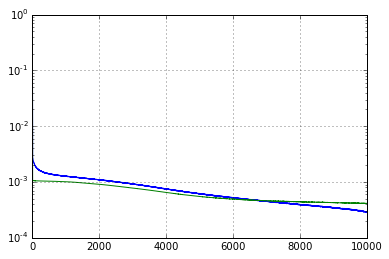

In [52]:
lossplot(net)
net.save_params_to('dense-2rec_image-with-local_999iters_00041_w.pkl')
with open('dense-2rec_image-with-local_999iters_00041_net.pkl','wb') as pk:
    pickle.dump(net, pk)

In [13]:
def another(n=1700):
    i = 0
    while i < n:
        yield i
        i += 1
g = another()

In [15]:
output_for_kaggle(test_local_revblur)

(array([], dtype=int64), array([], dtype=int64))
[]


In [49]:
net = NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('rnn1', lasagne.layers.RecurrentLayer),
        ('drop2', lasagne.layers.DropoutLayer),
        ('rnn2', lasagne.layers.RecurrentLayer),
        ('drop3', lasagne.layers.DropoutLayer),
#         ('dense', lasagne.layers.DenseLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 1, 96, 96),
    rnn1_num_units=500,
    rnn1_nonlinearity=lasagne.nonlinearities.leaky_rectify,
    drop2_p=.5,
    
    rnn2_num_units=500,
    rnn2_nonlinearity=lasagne.nonlinearities.leaky_rectify,
    drop3_p=.5,
    
#     dense_num_units=200,

    output_nonlinearity=None,
    output_num_units=30,

    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=theano.shared(np.float32(.01)),
    update_momentum=theano.shared(np.float32(.9)),
    
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
#         AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(100)
        ],

    regression=True,  
    max_epochs=2000,  
    verbose=True,
    )

In [52]:
with open('2layer_convo.pkl', 'rb') as pk:
    net = pickle.load(pk)

In [50]:
net.load_params_from('2rnn_500nodes_leakyrectify_00036.pkl')
# net.load_params_from('2rnn_1_dense_moredata_00036.pkl')

Loaded parameters to layer 'rnn1' (shape 1x500).
Loaded parameters to layer 'rnn1' (shape 9216x500).
Loaded parameters to layer 'rnn1' (shape 500).
Loaded parameters to layer 'rnn1' (shape 500x500).
Loaded parameters to layer 'rnn2' (shape 1x500).
Loaded parameters to layer 'rnn2' (shape 500x500).
Loaded parameters to layer 'rnn2' (shape 500).
Loaded parameters to layer 'rnn2' (shape 500x500).
Loaded parameters to layer 'output' (shape 500x30).
Loaded parameters to layer 'output' (shape 30).


In [55]:
# rnn_net_train = net.predict(train_data_tr.reshape(-1,1,96,96))
rnn_convo_train = net.predict(train_data_tr.reshape(-1,1,96,96))

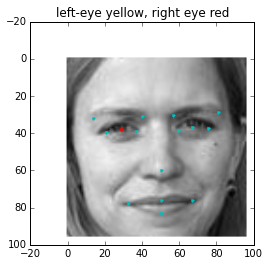

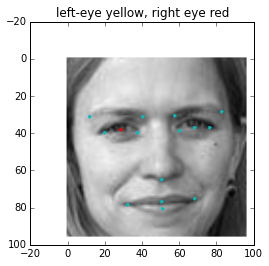

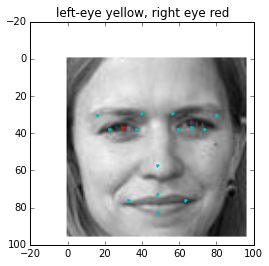

In [38]:
plotface(test_data_tr, rnn_net_test,n=1100)
plt.show()
plotface(test_data_tr, test_local_revblur,n=1100)
plt.show()
plotface(test_data_tr, rnn_convo_test,n=1100)

In [39]:
predictions = np.concatenate((rnn_net_test, test_local_revblur, rnn_convo_test), axis=1)

In [56]:
train_predictions = np.concatenate((rnn_net_train, train_local_revblur, rnn_convo_train), axis=1)

In [69]:
widenet = net = NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('rnn1', lasagne.layers.DenseLayer),
        ('drop2', lasagne.layers.DropoutLayer),
        ('rnn2', lasagne.layers.DenseLayer),
        ('drop3', lasagne.layers.DropoutLayer),
#         ('dense', lasagne.layers.DenseLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 9306),
    rnn1_num_units=500,
    rnn1_nonlinearity=lasagne.nonlinearities.leaky_rectify,
    drop2_p=.5,
    
    rnn2_num_units=500,
    rnn2_nonlinearity=lasagne.nonlinearities.leaky_rectify,
    drop3_p=.5,

    output_nonlinearity=None,
    output_num_units=30,

    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=theano.shared(np.float32(.01)),
    update_momentum=theano.shared(np.float32(.9)),
    
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(300)
        ],

    regression=True,  
    max_epochs=10000,  
    verbose=True,
    )

In [70]:
widenet.fit(np.concatenate((train_data_tr,train_predictions), axis=1), train_data_lb)

# Neural Network with 4919030 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9306
  1  rnn1       500
  2  drop2      500
  3  rnn2       500
  4  drop3      500
  5  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23342       0.04943      4.72251  0.51s
      2       0.07869       0.02362      3.33180  0.33s
      3       0.05818       0.01584      3.67316  0.29s
      4       0.05314       0.01612      3.29766  0.27s
      5       0.05452       0.02804      1.94413  0.26s
      6       0.04770       0.02333      2.04485  0.25s
      7       0.03899       0.00748      5.21190  0.33s
      8       0.03721       0.00979      3.80121  0.28s
      9       0.03427       0.01295      2.64688  0.25s
     10       0.02981       0.00369      8.07348  0.27s
     11       0.03228       0.01318      2.44998  0.26s
     12       0.02589       0.00735    

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10e84ac10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10e84ab90>,
     custom_score=None, drop2_p=0.5, drop3_p=0.5, input_shape=(None, 9306),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('rnn1', <class 'lasagne.layers.dense.DenseLayer'>), ('drop2', <class 'lasagne.layers.noise.DropoutLayer'>), ('rnn2', <class 'lasagne.layers.dense.DenseLayer'>), ('drop3', <class 'lasagne.layers.noise.DropoutLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10000, more_params={},
     objective=<function objective at 0x10e852cf8>,
     objective_loss_function=<function squared_error at 0x10e5d97d0>,
     on_epoch_finished=[<__main__.AdjustVariable object at 0x117c02750>, <__main__.AdjustVariable object at 0x117c02d50>, <__main__.EarlyStopping object at 0x117c02fd0>, <nolearn.lasagne.handlers.PrintLog insta

In [62]:
widepredictions = widenet.predict(predictions)

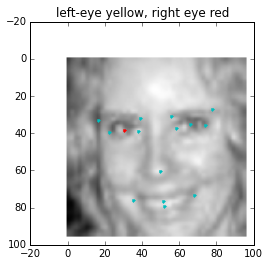

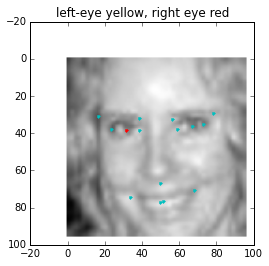

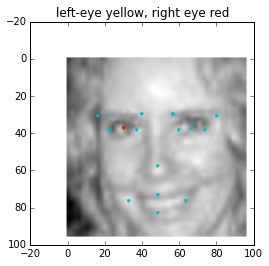

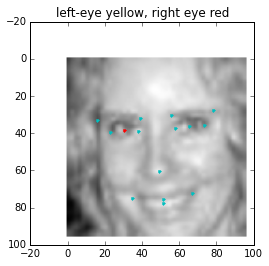

In [67]:
k=1104

plotface(test_data_tr, rnn_net_test,n=k)
plt.show()
plotface(test_data_tr, test_local_revblur,n=k)
plt.show()
plotface(test_data_tr, rnn_convo_test,n=k)
plt.show()
plotface(test_data_tr, widepredictions,n=k)

In [68]:
output_for_kaggle(widepredictions)

(array([], dtype=int64), array([], dtype=int64))
[]
